<a href="https://colab.research.google.com/github/FiFSCH/Masters_Degree_Sign_Language/blob/main/Masters_model_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision mediapipe

In [ ]:
!unzip data.zip -d data

# MobileNet V2 - TEST

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

In [ ]:
# Data transformations + augmentation
transform_mobile = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset_mobile = datasets.ImageFolder(root='./data/data', transform=transform_mobile)

# Display assigned classes
class_names_mobile = full_dataset_mobile.classes
print(class_names_mobile)

indices = torch.randperm(len(full_dataset_mobile))
train_idx, test_idx = indices[:int(len(full_dataset_mobile)*0.8)], indices[int(len(full_dataset_mobile)*0.8):]

# Training and testing set Creation
train_dataset_mobile = torch.utils.data.Subset(full_dataset_mobile, train_idx)
test_dataset_mobile = torch.utils.data.Subset(full_dataset_mobile, test_idx)

train_loader_mobile = DataLoader(train_dataset_mobile, batch_size=32, shuffle=True)
test_loader_mobile = DataLoader(test_dataset_mobile, batch_size=32, shuffle=False)

num_classes_mobile = len(full_dataset_mobile.classes)

In [ ]:
model_mobile = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model_mobile.classifier[1] = nn.Linear(model_mobile.classifier[1].in_features, num_classes_mobile)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.is_available())

model_mobile = model_mobile.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobile.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model_mobile.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_mobile:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model_mobile(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Evaluate on test dataset
    model_mobile.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader_mobile:

            images = images.to(device)
            labels = labels.to(device)
            outputs = model_mobile(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

# Save the trained model
torch.save(model_mobile.state_dict(), './TunedMobileNet.pth')


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
cuda
True


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.9586, Accuracy: 72.80%
Accuracy of the network on the test images: 95.87%
Epoch [2/10], Loss: 0.1739, Accuracy: 94.49%
Accuracy of the network on the test images: 94.77%
Epoch [3/10], Loss: 0.0834, Accuracy: 97.66%
Accuracy of the network on the test images: 98.07%
Epoch [4/10], Loss: 0.0988, Accuracy: 97.04%
Accuracy of the network on the test images: 95.59%
Epoch [5/10], Loss: 0.1322, Accuracy: 95.73%
Accuracy of the network on the test images: 94.21%
Epoch [6/10], Loss: 0.0832, Accuracy: 97.52%
Accuracy of the network on the test images: 98.35%
Epoch [7/10], Loss: 0.0480, Accuracy: 98.55%
Accuracy of the network on the test images: 98.35%
Epoch [8/10], Loss: 0.0521, Accuracy: 98.76%
Accuracy of the network on the test images: 99.45%
Epoch [9/10], Loss: 0.0250, Accuracy: 99.45%
Accuracy of the network on the test images: 99.45%
Epoch [10/10], Loss: 0.1011, Accuracy: 97.31%
Accuracy of the network on the test images: 94.49%


# SqueezeNet

In [ ]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import mediapipe as mp
import cv2
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.models import squeezenet1_0

In [ ]:
# Data transofmations + augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train + Test datasets creation
dataset_dir = './data/data'
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

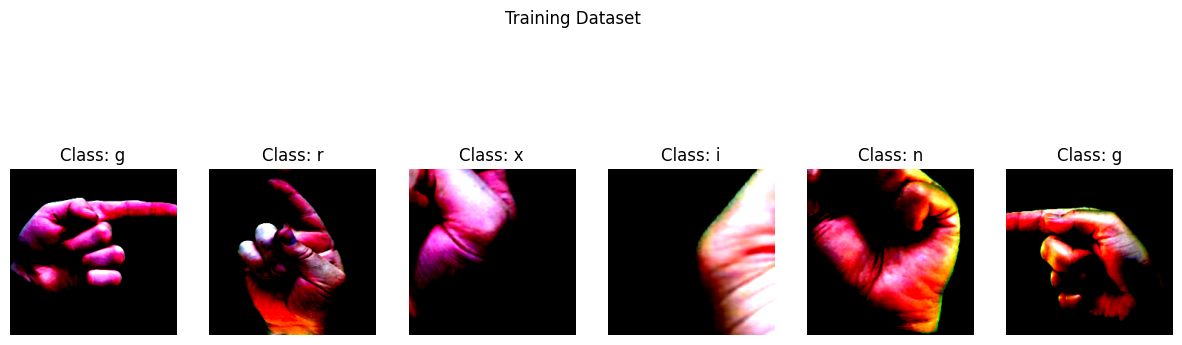

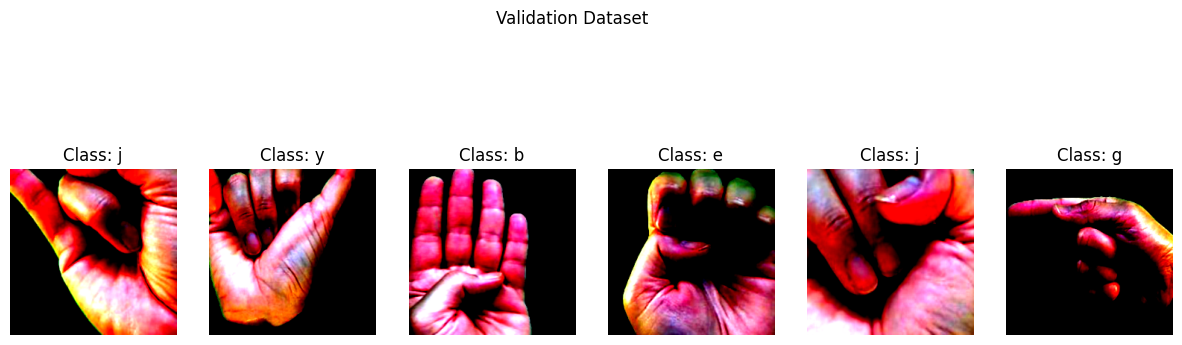

In [ ]:
# Visualize training and validation splits
def visualize_dataset(dataset, title, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"Class: {full_dataset.classes[label]}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

visualize_dataset(train_dataset, "Training Dataset")
visualize_dataset(val_dataset, "Validation Dataset")

In [ ]:
# Verify dataset split
len_train, len_val = len(train_dataset), len(val_dataset)
len_train, len_val, len(full_dataset.classes)  # Total counts, ensure split correctness

(1452, 363, 26)

In [ ]:
class_names = full_dataset.classes
print(class_names)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(full_dataset.classes)
model = squeezenet1_0(weights=True)

for param in model.parameters():
    param.requires_grad = False

# Adjust model to fit the dataset
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = num_classes

model = model.to(device)

# Loss function + optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 70

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 32.4MB/s]


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 10

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
            epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


# Save model
# I know it seems a bit weird that at first I save best model each time and then I load it just to save it again.
# I might further refactor that but I had no idea how to solve it during the time of implementation (I wanted to save this under different name)
# I was surprised to find out that there is no native implementation of early stopping in PyTorch
model.load_state_dict(torch.load('best_model.pth'))
torch.save(model.state_dict(), 'squeezenet_model.pth')

Epoch [1/70], Train Loss: 2.9944, Train Accuracy: 16.67%, Val Loss: 2.6201, Val Accuracy: 33.61%
Epoch [2/70], Train Loss: 2.2329, Train Accuracy: 44.49%, Val Loss: 1.8863, Val Accuracy: 51.24%
Epoch [3/70], Train Loss: 1.7186, Train Accuracy: 55.72%, Val Loss: 1.5663, Val Accuracy: 60.88%
Epoch [4/70], Train Loss: 1.4263, Train Accuracy: 63.77%, Val Loss: 1.4947, Val Accuracy: 57.30%
Epoch [5/70], Train Loss: 1.2252, Train Accuracy: 70.66%, Val Loss: 1.0932, Val Accuracy: 73.55%
Epoch [6/70], Train Loss: 1.0605, Train Accuracy: 73.28%, Val Loss: 1.0958, Val Accuracy: 71.07%
Epoch [7/70], Train Loss: 1.0149, Train Accuracy: 74.66%, Val Loss: 1.0633, Val Accuracy: 68.60%
Epoch [8/70], Train Loss: 0.9387, Train Accuracy: 77.34%, Val Loss: 0.9765, Val Accuracy: 73.28%
Epoch [9/70], Train Loss: 0.8754, Train Accuracy: 78.65%, Val Loss: 0.9905, Val Accuracy: 70.25%
Epoch [10/70], Train Loss: 0.7992, Train Accuracy: 81.34%, Val Loss: 0.7872, Val Accuracy: 78.24%
Epoch [11/70], Train Loss: 0.

<ipython-input-9-a6fe7ef1d89e>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
